This notebook contains the fully working code for our project, from the puzzle image to the rebuilt puzzle, along with images of intermediary results as seen in our repor.

In [1]:
import cv2
import numpy as np
from puzzle_solver import plot
from puzzle_solver.tile_detector import detect_tiles
from puzzle_solver.convex_hull import find_lock_points, classify_lock_points, detect_corners
from puzzle_solver.edge import EdgeType, PuzzleEdge
from puzzle_solver.utils import get_wrapped_contour_section, find_contour_idx
from puzzle_solver.puzzle_piece import PuzzlePiece
import scipy

## Piece extraction

In this section, we'll extract the pieces of the puzzle from the background.

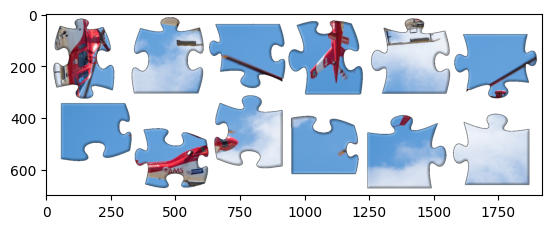

In [2]:
img = cv2.imread("../samples/helico3.png")
plot(img)

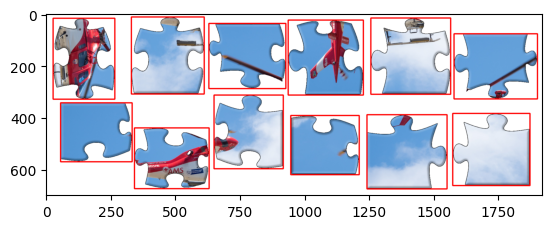

In [3]:
boxes, centroids, num_labels, labels = detect_tiles(img)

output = img.copy()
for box in np.array(boxes)[1:]:
    cv2.rectangle(output, box[0], box[1], (0, 0, 255), 3)
plot(output)

12 puzzle pieces found


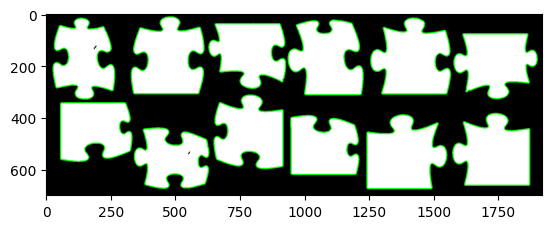

In [4]:
# Get contours
contours, _ = cv2.findContours((labels > 0).astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

## Draw contours
labels_image = cv2.cvtColor((labels > 0).astype(np.uint8) * 255, cv2.COLOR_GRAY2BGR)
cv2.drawContours(labels_image, contours, -1, (0, 255, 0), 3)
plot(labels_image)

print(f"{len(contours)} puzzle pieces found")

## Corner and edge classification

To detect the piece's corner and edges, we start by extracting the image's convex hull. We then determine convexity defects, and filter those that are further from the hull than a given threshold. Those filtered convexity defects are called "lock points" going forward.

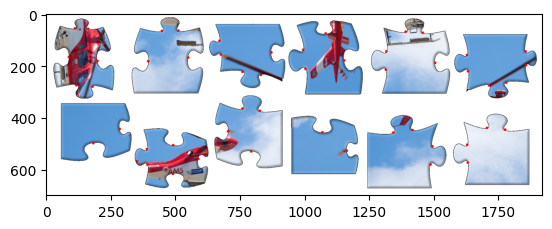

In [5]:
lock_points, defects_start_end = find_lock_points(contours)

lock_point_image = img.copy()
for contour, contour_lock_points in zip(contours, lock_points):
    for lock_point in contour_lock_points:
        cv2.circle(lock_point_image, tuple(contour[lock_point][0]), 5, [0, 0, 255], cv2.FILLED)
plot(lock_point_image)

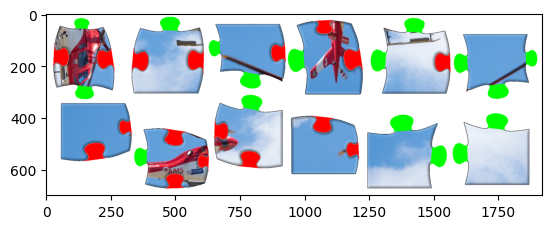

In [6]:
head_sections, hole_sections, defect_labels = classify_lock_points(contours, lock_points, defects_start_end)

lock_point_image = img.copy()
for local_head_section in head_sections:
    cv2.drawContours(lock_point_image, local_head_section, -1, color=[0, 255, 0], thickness=cv2.FILLED)
for local_hole_section in hole_sections:
    cv2.drawContours(lock_point_image, local_hole_section, -1, color=[0, 0, 255], thickness=cv2.FILLED)
plot(lock_point_image)

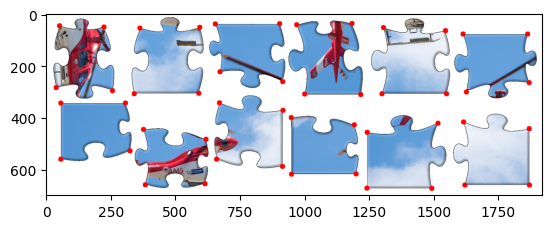

In [7]:
corners = detect_corners(img, contours, head_sections, hole_sections)

corner_img = img.copy()
for corner in corners:
    for point in corner:
        cv2.circle(corner_img, point, radius=10, color=[0, 0, 255], thickness=cv2.FILLED)
plot(corner_img)

Now that we have the piece's corners, we can finally extarct each edge. We use a `PuzzleEdge` object to hold that information.

In [8]:
all_edges = []

for i, piece_corners in enumerate(corners):
    for j in range(len(piece_corners)):
        start_coord = piece_corners[j]
        end_coord = piece_corners[(j + 1) % len(piece_corners)]
        contour_idx = find_contour_idx(contours, start_coord)  # contours and corners may not have the same order
        contour = contours[contour_idx]

        # Get the section of the contour associated to the edge
        start_idx = np.argmin(np.linalg.norm(contour[:, 0, :] - start_coord, axis=-1))
        end_idx = np.argmin(np.linalg.norm(contour[:, 0, :] - end_coord, axis=-1))
        contour_section = get_wrapped_contour_section(contour, start_idx, end_idx + 1)

        # Determine the edge type
        edge_type = EdgeType.FLAT
        for (defect_start, defect_end), label in zip(defects_start_end[contour_idx], defect_labels[contour_idx]):
            if (contour[defect_start] == contour_section).all(axis=-1).any() and (
                contour[defect_end] == contour_section
            ).all(axis=-1).any():
                edge_type = label
        all_edges.append(PuzzleEdge(piece_id=contour_idx, piece_num=j, coords=contour_section, type=edge_type))

# Re-map the piece_num attribute of edges so that it encodes orientation
# The topmost edge has a piece_num of 0, the leftmost one of 1,
# the bottom one of 2 and the right one of 3
for left_edge in all_edges:
    for i in range(len(all_edges) // 4):
        edges = [e for e in all_edges if e.piece_id == i]
        y = [(e.coords[:, 0, 1].min(), e.coords[:, 0, 1].sum()) for e in edges]
        start_piece = edges[y.index(sorted(y)[0])].piece_num
        for e in edges:
            e.piece_num = (e.piece_num - start_piece) % 4

Plot extracted edges, colored by type (flat, head or hole):

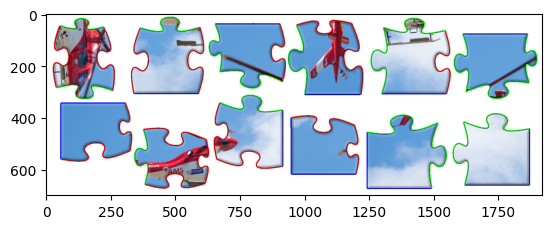

In [9]:
edge_img = img.copy()
for left_edge in all_edges:
    if left_edge.type == EdgeType.FLAT:  # Blue
        color = [255, 0, 0]
    elif left_edge.type == EdgeType.HEAD:  # Green
        color = [0, 255, 0]
    elif left_edge.type == EdgeType.HOLE:  # Red
        color = [0, 0, 255]
    for i in range(len(left_edge.coords) - 1):
        cv2.line(edge_img, left_edge.coords[i, 0, :], left_edge.coords[i + 1, 0, :], color, thickness=2)

plot(edge_img)

## Match pieces  

### Get puzzle border pieces

In this section, we describe the first step of the patching process which is to find the pieces that constitute the border of the puzzle.  
We select one of the borders of the puzzle, and we calculate the distance between this piece and the potential matching pieces that are on the borders of the puzzle (the ones having at least one flat border). We iterate this step until we get the full border of the puzzle. 

In [10]:
# Create puzzle pieces

pieces: list[PuzzlePiece] = []
for i in range(len(contours)):
    edges = [e for e in all_edges if e.piece_id == i]
    pieces.append(PuzzlePiece(img, contours[i], edges, i))

Specify your puzzle's shape below:

In [11]:
PUZZLE_SHAPE = (4, 3)

In [12]:
# Find external contour pieces
puzzle = [[None] * PUZZLE_SHAPE[0] for _ in range(PUZZLE_SHAPE[1])]  # Will be filled with the puzzle pieces
corner = [p for p in pieces if p.corner][
    3
]  # Pick an arbitrary corner. We chose the top-left to avoid having to rotate the final puzzle

# We start from the top-left corner
# Set corner rotation so it fits there
piece_num = [e.type for e in corner.edges].index(EdgeType.FLAT)
if corner.edges[-1] == 0 and piece_num == 0:
    piece_num = 3
corner.rot = (-piece_num) % 4

# Start filling the puzzle!
puzzle[0][0] = corner

piece_source = corner
used_pieces = {corner.id}

for direction in range(4):  # 0 = left, 1= down, 2 = right, 3 = up
    piece_num = 0
    if direction % 2 == 0:
        size = len(puzzle[0])
    else:
        size = len(puzzle)
    for piece_num in range(size - 1 - int(direction == 3)):  # If direction==3, we loop back to the first piece
        left_edge = [e for e in piece_source.edges if (e.piece_num + piece_source.rot) % 4 == (3 - direction) % 4][
            0
        ]  # Find source piece's left end
        possible_edges = []  # Edges compatible with the source piece's shape, and allowing a flat edge on the outside
        for piece in pieces:
            if piece.id == piece_source.id or piece.id in used_pieces:  # Can't reuse piece
                continue
            for i in range(len(piece.edges)):
                if (
                    piece.edges[i].type != left_edge.type and piece.edges[i].type != EdgeType.FLAT
                ):  # Check HOLE/HEAD & HEAD/HOLE
                    if piece.edges[(i - 1) % 4].type == EdgeType.FLAT:  # Check Flat to the right
                        possible_edges.append(piece.edges[i])
        # Compute distance between normalized edges
        best_idx = np.argmin(
            [
                scipy.spatial.distance.cdist(left_edge.norm, possible_edge.norm).min(axis=-1).sum()
                for possible_edge in possible_edges
            ]
        )
        best_edge = possible_edges[best_idx]

        best_piece = pieces[best_edge.piece_id]
        # Rotate piece so it can fit
        best_piece.rot = (2 - (best_piece.rot + best_edge.piece_num) + left_edge.piece_num + piece_source.rot) % 4

        # Place the new piece on the puzzle
        if direction == 0:
            puzzle[0][piece_num + 1] = best_piece
        elif direction == 1:
            puzzle[piece_num + 1][len(puzzle[0]) - 1] = best_piece
        elif direction == 2:
            puzzle[len(puzzle) - 1][len(puzzle[0]) - 2 - piece_num] = best_piece
        elif direction == 3:
            puzzle[len(puzzle) - 2 - piece_num][0] = best_piece

        piece_source = best_piece
        used_pieces.add(piece_source.id)

### Fill puzzle internal pieces

The final step of the matching process, know that we have the border pieces of the puzzle, is to find the inside pieces. The method is the same : we start from one of the corner of the border that we just created, and we find the most matching pieces for the first raw, and so on. This time there ar emore constrainst on the pieces, and we can computer a more complex similarity function, taking several edges into account.

In [13]:
piece_source = puzzle[1][0]

# We fill the inside of the puzzle left to right and top to bottom
for row_idx in range(1, len(puzzle) - 1):
    for piece_num in range(1, len(puzzle[0]) - 1):
        left_edge = [e for e in piece_source.edges if (e.piece_num + piece_source.rot) % 4 == 3][0]
        possible_edges = []
        for piece in pieces:
            if piece.id == piece_source.id or piece.id in used_pieces:
                continue
            # This time we also take the top edge into account
            top_edge = [
                e
                for e in puzzle[row_idx - 1][piece_num].edges
                if (e.piece_num + puzzle[row_idx - 1][piece_num].rot) % 4 == 2
            ][0]
            # And the bottom edge if we're on the penultimate row
            if row_idx == len(puzzle) - 2:
                bottom_edge = [
                    e
                    for e in puzzle[row_idx + 1][piece_num].edges
                    if (e.piece_num + puzzle[row_idx + 1][piece_num].rot) % 4 == 0
                ][0]
            for i in range(len(piece.edges)):
                if piece.edges[i].type != left_edge.type:  # Check HOLE/HEAD on the left
                    if piece.edges[(i - 1) % 4].type != top_edge.type:  # Check HOLE/HEAD on the top
                        possible_edges.append((piece.edges[i], piece.edges[(i - 1) % 4], piece.edges[(i + 1) % 4]))
        # We compute distance both to the left and to the top
        d2 = np.array(
            [
                scipy.spatial.distance.cdist(left_edge.norm, possible_edge[0].norm).min(axis=-1).sum()
                for possible_edge in possible_edges
            ]
        )
        d1 = np.array(
            [
                scipy.spatial.distance.cdist(top_edge.norm, possible_edge[1].norm).min(axis=-1).sum()
                for possible_edge in possible_edges
            ]
        )
        # And the bottom if possible
        if row_idx == len(puzzle) - 2:
            d3 = np.array(
                [
                    scipy.spatial.distance.cdist(bottom_edge.norm, possible_edge[2].norm).min(axis=-1).sum()
                    for possible_edge in possible_edges
                ]
            )
            d2 += d3
        best_idx = np.argmin(d1 + d2)
        best_edge = possible_edges[best_idx][0]
        best_piece = pieces[best_edge.piece_id]
        best_piece.rot = (2 - (best_piece.rot + best_edge.piece_num) + left_edge.piece_num + piece_source.rot) % 4

        puzzle[row_idx][piece_num] = best_piece

        piece_source = best_piece
        used_pieces.add(piece_source.id)

## Visualisation of the solved puzzle 

We don't try to compute the best fit for display purposes, so we tend to overestmate the distance between pieces.

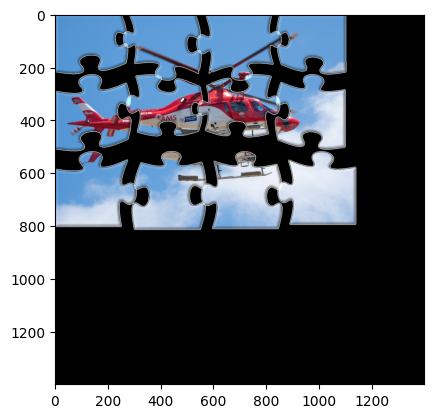

In [20]:
res = np.zeros((img.shape[0] * 2, img.shape[0] * 2, 3), dtype=np.uint8)
delta_y = 0
next_delta_y = 0
for i in range(len(puzzle)):
    delta_x = 0
    for j in range(len(puzzle[0])):
        piece = puzzle[i][j]
        piece.rotate()
        piece.place(res, (delta_x, delta_y))
        delta_x += piece.img.shape[1] - 20
        if j == 0:
            next_delta_y = piece.img.shape[0]
    delta_y += next_delta_y

plot(res)